In [1]:
import math
import numpy as np
import torch
import torch.distributions as td
from torch.distributions import constraints, Gamma, MultivariateNormal
from torch.distributions.multivariate_normal import _batch_mv, _batch_mahalanobis
from torch.distributions.distribution import Distribution
from torch.distributions.utils import broadcast_all, lazy_property, _standard_normal
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(context="paper", style="whitegrid", font_scale=1.5)

In [2]:
class MultivariateT(MultivariateNormal):
    """
    Multivariate Student-t distribution, using hierarchical Gamma sampling.
    (see https://arxiv.org/abs/1402.4306)
    We only allow degrees of freedom >= 2 for now,
    because otherwise the covariance is undefined.
    """
    arg_constraints = {'df': constraints.positive,
                       'loc': constraints.real_vector,
                       'covariance_matrix': constraints.positive_definite,
                       'precision_matrix': constraints.positive_definite,
                       'scale_tril': constraints.lower_cholesky}
    support = constraints.real
    has_rsample = True
    
    def __init__(self,
                 df=3.,
                 loc=0.,
                 covariance_matrix=None,
                 precision_matrix=None,
                 scale_tril=None,
                 validate_args=None):
        assert df >= 2., "We need more than 2 degrees of freedom for nice properties"
        super().__init__(loc=loc,
                 covariance_matrix=covariance_matrix,
                 precision_matrix=precision_matrix,
                 scale_tril=scale_tril,
                 validate_args=validate_args)
        self.df, = broadcast_all(df)
        self.gamma = Gamma(concentration=self.df/2., rate=1./2.)
        

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        r_inv = self.gamma.sample(sample_shape=sample_shape)
        r_inv = torch.unsqueeze(r_inv, -1)
        eps, r_inv = broadcast_all(eps, r_inv)
        r = 1/r_inv
        return self.loc + (r * (self.df - 2.))*_batch_mv(self._unbroadcasted_scale_tril, eps)
    
    
    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        diff = value - self.loc
        M = _batch_mahalanobis(self._unbroadcasted_scale_tril, diff)
        half_log_det = self._unbroadcasted_scale_tril.diagonal(dim1=-2, dim2=-1).log().sum(-1)
        dim = self._event_shape[0]
        lp = torch.lgamma((dim+self.df)/2.) \
                - ((dim/2.) * torch.log(math.pi * (self.df - 2.))) \
                - torch.lgamma(self.df / 2.) \
                - half_log_det \
                - ((self.df+dim)/2.) * torch.log(1 + (M/(self.df-2.)))
        return lp
    
    
    def cdf(self, value):
        raise NotImplementedError


    def icdf(self, value):
        raise NotImplementedError


    def entropy(self):
        raise NotImplementedError

In [3]:
t_dist = MultivariateT(df=3., loc=torch.tensor([0., 0.]), covariance_matrix=torch.tensor([[2.,1.],[1.,2.]]))

In [4]:
t_dist.log_prob(torch.tensor([1.,1.]))

tensor(-2.5656)

In [5]:
sample = t_dist.sample(sample_shape=(1000,))

In [6]:
t_dist.log_prob(sample)[:10]

tensor([-2.1667, -2.2166, -1.4190, -8.8037, -3.6343, -1.4008, -1.3458, -2.2257,
        -3.0618, -3.7272])

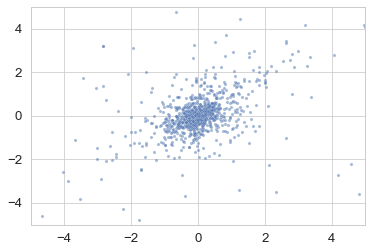

In [7]:
fig, ax = plt.subplots()
sns.scatterplot(x=sample[:,0], y=sample[:,1], s=10, alpha=0.5)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5);